In [9]:
import torch
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

In [21]:
from cs231n.data_utils import load_imagenet_val
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD

In [16]:
from PIL import Image

## 辅助函数

In [14]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)


def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)


def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled


def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

## 加载预训练模型

In [4]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

## 加载一些图片

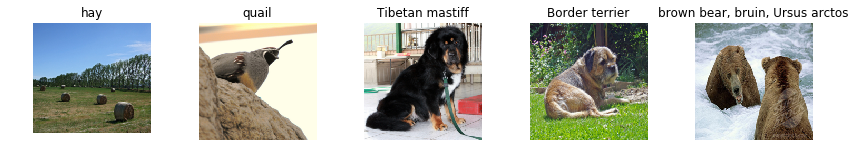

In [10]:
X, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

## Saliency Maps测试

### Saliency Maps原理

A saliency map tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape (3, H, W) then this gradient will also have shape (3, H, W); for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape (H, W) and all entries are nonnegative.

Saliency Maps相当于是计算图像的每一个pixel是如何影响一个分类器的, 或者说分类器对图像中每一个pixel哪些认为是重要的.

会计算图像每一个像素点的梯度。如果图像的形状是(3, H, W)，这个梯度的形状也是(3, H, W)；对于图像中的每个像素点，这个梯度告诉我们当像素点发生轻微改变时，正确分类分数变化的幅度。

计算saliency map的时候，需要计算出梯度的绝对值，然后再取三个颜色通道的最大值；因此最后的saliency map的形状是(H, W)为一个通道的灰度图。

In [11]:
# Example of using gather to select one entry from each row in PyTorch
# 用来返回matrix指定行某个位置的值
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())


gather_example()

tensor([[ 1.9855,  2.2798,  0.1243,  0.1829, -0.0163],
        [ 1.3050,  0.1160, -0.1914, -1.8250,  2.2725],
        [ 0.8732,  0.3755,  0.1851, -0.2554,  0.1941],
        [-0.0683,  0.5146,  0.1236, -0.5311,  0.9159]])
tensor([1, 2, 1, 3])
tensor([ 2.2798, -0.1914,  0.3755, -0.5311])


In [29]:
torch.LongTensor(y).view(-1,1)

tensor([[958],
        [ 85],
        [244],
        [182],
        [294]])

In [23]:
def compute_saliency_maps(X, y, model):
    """
    X表示图片, y表示分类结果, model表示使用的分类模型
    
    Input : 
    - X : Input images : Tensor of shape (N, 3, H, W)
    - y : Label for X : LongTensor of shape (N,)
    - model : A pretrained CNN that will be used to computer the saliency map
    
    Return :
    - saliency : A Tensor of shape (N, H, W) giving the saliency maps for the input images
    """
    # 确保model是test模式
    model.eval()
    
    # 确保X是需要gradient
    X.requires_grad_()
    
    saliency = None
    
    logits = model.forward(X)
    logits = logits.gather(1, y.view(-1, 1)).squeeze() # 得到正确分类
    logits.backward(torch.FloatTensor([1., 1., 1., 1., 1.])) # 只计算正确分类部分的loss
    
    saliency = abs(X.grad.data) # 返回X的梯度绝对值大小
    saliency, _ = torch.max(saliency, dim=1)
    
    return saliency.squeeze()

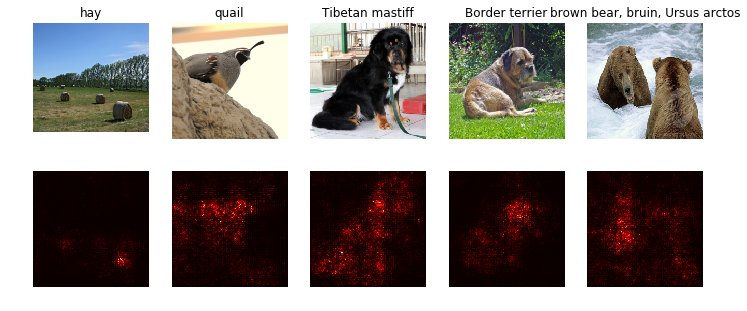

In [24]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()


show_saliency_maps(X, y)